# 📦 Proyecto Final - Data Science I  
## Predicción del Volumen Transferido en Operaciones Logísticas Internas



# 📑 Índice

1. Introducción y Objetivo  
2. Importación de Librerías  
3. Carga y Filtrado del Dataset  
4. Hipótesis de Trabajo  
5. Análisis Exploratorio de Datos (EDA)  
6. Ingeniería de Características  
7. Preprocesamiento de Datos  
8. Agrupación de Datos (día-camión-sucursal)  
9. División del Dataset  
10. Entrenamiento del Modelo de Regresión  
11. Evaluación del Modelo  
12. Importancia de Variables  
13. Conclusiones Finales

## 1. Introducción y Objetivo



Este proyecto se basa en datos reales de una empresa de retail dedicada a la comercialización de productos para el hogar, que gestiona transferencias logísticas internas entre sus distintas sucursales. La logística cumple un rol central en la eficiencia operativa, especialmente en entornos con alta rotación de productos y múltiples puntos de distribución.

### Problemática
El objetivo del presente análisis es predecir el volumen total diario que será transferido a cada sucursal desde el Centro de Operaciones Logísticas. Esta predicción permitirá anticipar la demanda logística por sucursal, mejorar la asignación de camiones y optimizar los recursos operativos.

El modelo se orienta a estimar la **cantidad de metros cúbicos transferidos por día y por sucursal**, sin requerir el detalle individual de productos. Esto lo convierte en una herramienta práctica de planificación a nivel operativo.

### Descripción del Dataset
El dataset contiene información detallada de cada transferencia realizada, incluyendo:
- Fecha y hora de emisión
- Origen y destino
- Artículo, familia y rubro del producto
- Tipo de envío, camión utilizado
- Volumen y peso unitario
- Costos unitarios y totales

A partir de esta información, se realizará una agregación de datos por día y sucursal, seguida de un proceso de limpieza, ingeniería de variables y entrenamiento de un modelo de regresión supervisada.


## 2. Importación de librerías

In [1]:
# Importación de librerías necesarias

# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Modelado (regresión)
from sklearn.ensemble import RandomForestRegressor

# Evaluación del modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Estilo de gráficos
sns.set(style="whitegrid")


## 3. Carga y Filtrado del Dataset



En esta sección se carga el dataset actualizado desde el repositorio local, se realiza el filtrado por origen (Centro de Operaciones Logísticas) y se preparan nuevas variables que enriquecerán el análisis posterior, como:

- Conversión correcta del campo fecha
- Extracción de variables temporales: año, mes, día de la semana y nombre del mes
- Cálculo del volumen real transferido (`cantidad × volumen_unitario`)
- Conversión de volumen a tipo numérico
- Eliminación de columnas irrelevantes

Esto permite preparar el dataset para el análisis exploratorio (EDA) y para el entrenamiento de modelos de regresión.


In [2]:
# Cargar dataset actualizado desde GitHub
url = 'https://github.com/aparajon89/Proyecto-Final-Augusto-Parajon-CODER/raw/refs/heads/main/data/Coder_DATASET_DS_APARAJON.csv'

# Leer CSV con encoding y separador adecuados
df = pd.read_csv(url, encoding='ISO-8859-1', sep=';', on_bad_lines='skip', low_memory=False)

# Convertir columna 'Volumen' de texto a float
df['Volumen'] = df['Volumen'].str.replace(',', '.').astype(float)

# Filtrar solo transferencias desde el Centro de Operaciones Logísticas
df = df[df['Origen'] == 'Centro de Operaciones Logistic'].copy()

# Convertir columna 'Fecha' a tipo datetime (formato día/mes/año)
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True, errors='coerce')

# Crear variables temporales adicionales
df['Año'] = df['Fecha'].dt.year
df['Mes'] = df['Fecha'].dt.month
df['NombreMes'] = df['Fecha'].dt.strftime('%B')
df['DiaSemana'] = df['Fecha'].dt.day_name()

# Mapas para traducir nombre de días y meses al español
dias_map = {
    'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles',
    'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'
}
meses_map = {
    'January': 'Enero', 'February': 'Febrero', 'March': 'Marzo', 'April': 'Abril',
    'May': 'Mayo', 'June': 'Junio', 'July': 'Julio', 'August': 'Agosto',
    'September': 'Septiembre', 'October': 'Octubre', 'November': 'Noviembre', 'December': 'Diciembre'
}

# Asignar traducciones
df['DiaSemana'] = df['DiaSemana'].map(dias_map)
df['NombreMes'] = df['NombreMes'].map(meses_map)

# Convertir columnas numéricas con coma decimal
columnas_a_convertir = ['Cantidad', 'Peso', 'Costo Unit.', 'Costo Total']
for col in columnas_a_convertir:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

# Calcular volumen total transferido por fila
df['VolumenTotal'] = df['Volumen'] * df['Cantidad']

# Vista preliminar
df[['Fecha', 'Año', 'Mes', 'NombreMes', 'DiaSemana', 'Camion', 'Destino', 'VolumenTotal']].head()


,Fecha,Año,Mes,NombreMes,DiaSemana,Camion,Destino,VolumenTotal
0,2022-01-03,2022,1,Enero,Lunes,Camión 3,25 de Mayo,0.6604
1,2022-01-03,2022,1,Enero,Lunes,Camión 3,25 de Mayo,0.6100
2,2022-01-03,2022,1,Enero,Lunes,Camión 3,25 de Mayo,0.9760
3,2022-01-03,2022,1,Enero,Lunes,Camión 3,25 de Mayo,0.0840
4,2022-01-03,2022,1,Enero,Lunes,Camión 3,25 de Mayo,0.6650


In [3]:
# Verificar valores nulos
nulos = df.isnull().sum()
print("Valores nulos por columna:")
print(nulos[nulos > 0])


Valores nulos por columna:
Hora            127312
Estado          127312
Emitido por     127312
Modelo           29324
Cantidad          2853
Costo Unit.        127
Costo Total        127
Volumen            127
Peso               127
Familia            127
Rubro              127
VolumenTotal      2979
dtype: int64


Durante la exploración inicial del dataset se identificaron valores nulos en varias columnas, entre ellas `Modelo`, `Cantidad`, `Volumen`, `Peso`, `Costo Unit.`, `Familia`, entre otras.

En particular, se detectó que:
- Algunas columnas como `Hora`, `Estado` y `Emitido por` contenían nulos en más del 95% de los registros y no aportaban información relevante al análisis, por lo que fueron eliminadas.
- La columna `Modelo`, además de contener muchos nulos, fue considerada irrelevante para el objetivo del proyecto y también fue eliminada.
- El resto de las columnas afectadas (`Volumen`, `Cantidad`, `Costo Unit.`, `Costo Total`, `Peso`, `Familia` y `Rubro`) fueron tratadas eliminando las filas correspondientes. Este procedimiento representó menos del 0,03% del total del dataset, por lo que no compromete la integridad del análisis ni introduce sesgo significativo.

Con este tratamiento, se garantiza que el dataset utilizado para el entrenamiento del modelo esté limpio, completo y contenga únicamente variables con capacidad explicativa.

In [4]:
#  Eliminamos la columnas Hora, Estado, Emitido por y Modelo por su irrelevancia y alta cantidad de valores nulos
df = df.drop(columns=['Hora', 'Estado', 'Emitido por', 'Modelo'])

#  Eliminamos las filas que contienen valores nulos
columnas_clave = ['VolumenTotal', 'Cantidad', 'Costo Unit.', 'Costo Total', 'Peso', 'Familia', 'Rubro']
df = df.dropna(subset=columnas_clave)


In [5]:
# Verificamos nuevamente valores nulos
nulos = df.isnull().sum()
print("Valores nulos por columna:")
print(nulos[nulos > 0])

Valores nulos por columna:
Series([], dtype: int64)


## 4. Hipótesis de Trabajo





Se plantea la siguiente hipótesis:

El volumen transferido por camión puede predecirse principalmente en función del día de la semana, la sucursal de destino y la época del año.

La empresa realiza operaciones logísticas de lunes a viernes durante jornada completa y los sábados en media jornada. Si bien existe un cronograma preestablecido de reposiciones hacia cada sucursal, el volumen solicitado por estas varía en función de su demanda, la estacionalidad y el comportamiento histórico.

Por lo tanto, se espera que el modelo de regresión pueda aprender patrones en el volumen transferido utilizando variables como:



*   Día operativo (con distinción sábado vs. lunes-viernes)
*   Sucursal de destino
*   Época del año (mes)


Este modelo tendrá como objetivo anticipar los volúmenes a despachar a cada sucursal en el futuro, contribuyendo a una planificación más eficiente de la capacidad logística, la asignación de camiones y la preparación de pedidos.

## 5. Análisis Exploratorio de Datos (EDA)




En esta sección se analiza el comportamiento del volumen transferido según las variables más relevantes identificadas en la hipótesis de trabajo: **Día de la semana**, **Sucursal de destino** y **Mes del año**.

El objetivo es validar si existen patrones regulares que justifiquen su inclusión como variables explicativas en el modelo de regresión.

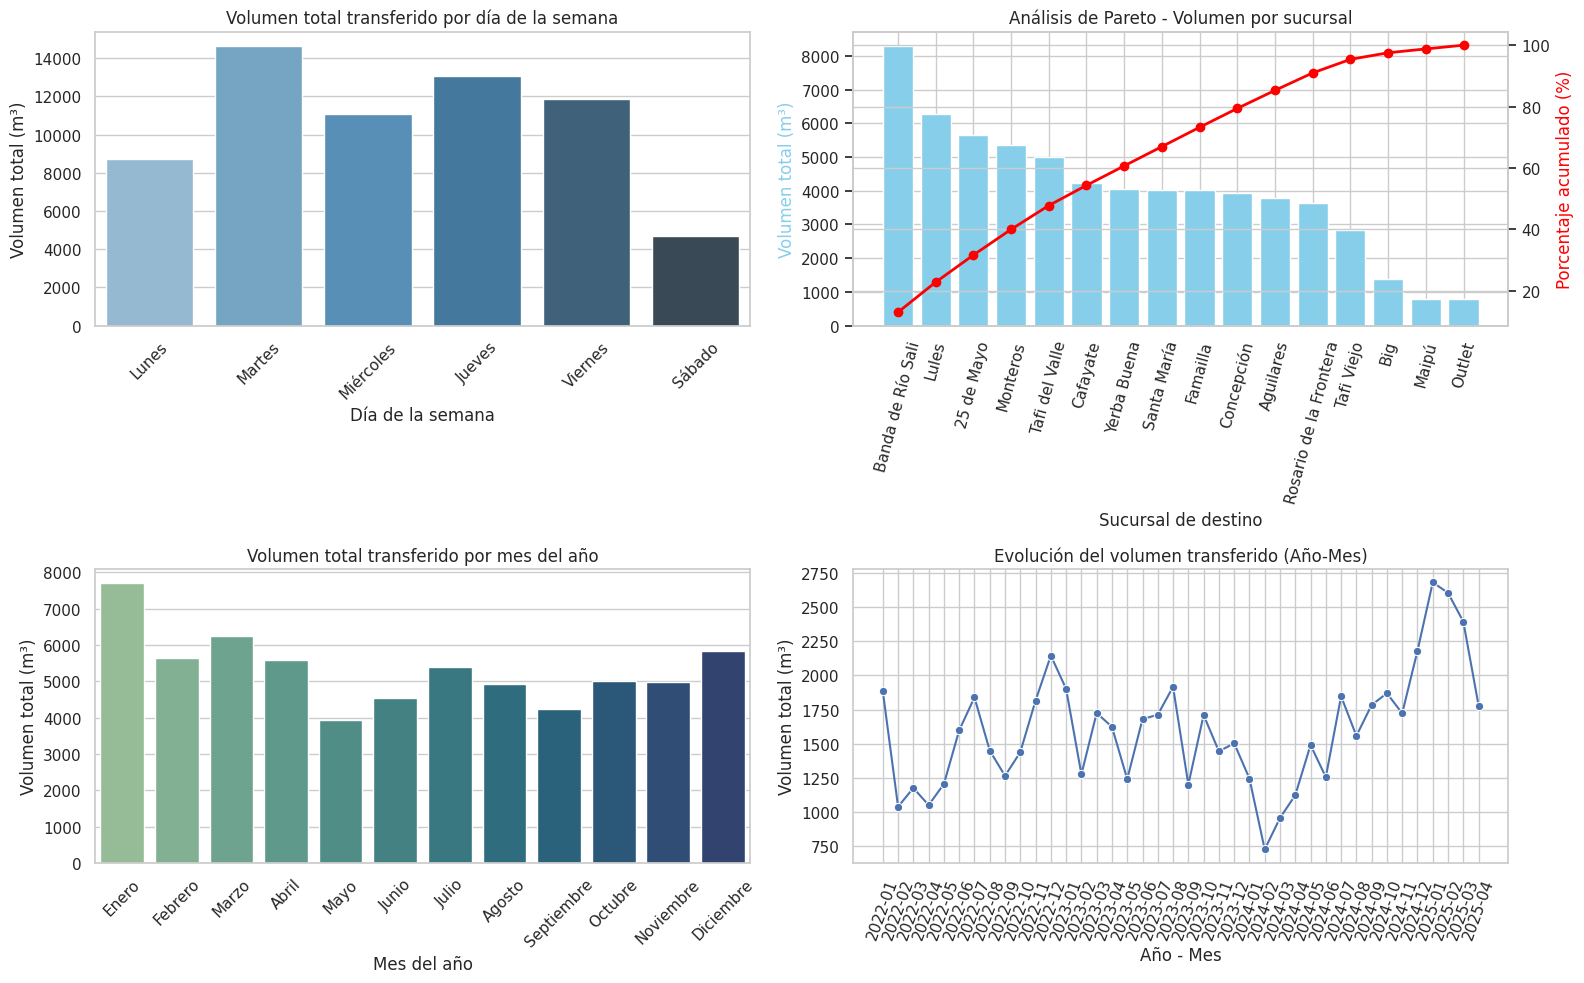

In [6]:
# Asegurar que 'Fecha' esté en formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True, errors='coerce')

# Generar variables temporales necesarias
df['DiaSemana'] = df['Fecha'].dt.day_name()
df['NombreMes'] = df['Fecha'].dt.month_name()

# Agrupar por Fecha y Destino
df_diario = df.groupby(['Fecha', 'Destino'], as_index=False).agg({
    'VolumenTotal': 'sum',
    'Cantidad': 'sum',
    'Peso': 'sum',
    'Costo Total': 'sum',
    'Costo Unit.': 'mean',
    'Camion': lambda x: x.mode().iloc[0] if not x.mode().empty else 'SinDato',
    'DiaSemana': 'first',
    'NombreMes': 'first'
})

# Generar columnas desde la fecha
df_diario['DiaSemana'] = df_diario['Fecha'].dt.day_name()
df_diario['NombreMes'] = df_diario['Fecha'].dt.month_name()

# Mapas de traducción al español (si vienen en inglés)
dias_map = {
    'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles',
    'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'
}
meses_map = {
    'January': 'Enero', 'February': 'Febrero', 'March': 'Marzo', 'April': 'Abril',
    'May': 'Mayo', 'June': 'Junio', 'July': 'Julio', 'August': 'Agosto',
    'September': 'Septiembre', 'October': 'Octubre', 'November': 'Noviembre', 'December': 'Diciembre'
}

df_diario['DiaSemana'] = df_diario['DiaSemana'].map(dias_map)
df_diario['NombreMes'] = df_diario['NombreMes'].map(meses_map)

# Ordenes explícitos
orden_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado']
orden_meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
               'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# Año-Mes para gráfica temporal
df_diario['AñoMes'] = df_diario['Fecha'].dt.to_period('M').astype(str)

# Agrupaciones
volumen_total_dia = df_diario.groupby('DiaSemana')['VolumenTotal'].sum().reindex(orden_dias)
volumen_por_destino = df_diario.groupby('Destino')['VolumenTotal'].sum().sort_values(ascending=False)
cumulative_percentage = volumen_por_destino.cumsum() / volumen_por_destino.sum() * 100
volumen_mes = df_diario.groupby('NombreMes')['VolumenTotal'].sum().reindex(orden_meses)
volumen_ayomes = df_diario.groupby('AñoMes')['VolumenTotal'].sum()

# Visualización
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Gráfico 1: Volumen por día de la semana
sns.barplot(
    x=volumen_total_dia.index,
    y=volumen_total_dia.values,
    hue=volumen_total_dia.index,
    palette="Blues_d",
    legend=False,
    ax=axs[0, 0]
)
axs[0, 0].set_title("Volumen total transferido por día de la semana")
axs[0, 0].set_ylabel("Volumen total (m³)")
axs[0, 0].set_xlabel("Día de la semana")
axs[0, 0].tick_params(axis='x', rotation=45)

# Gráfico 2: Pareto por sucursal
axs2 = axs[0, 1].twinx()
axs[0, 1].bar(volumen_por_destino.index, volumen_por_destino.values, color='skyblue')
axs2.plot(volumen_por_destino.index, cumulative_percentage, color='red', marker='o', linewidth=2)
axs[0, 1].set_title("Análisis de Pareto - Volumen por sucursal")
axs[0, 1].set_ylabel("Volumen total (m³)", color='skyblue')
axs2.set_ylabel("Porcentaje acumulado (%)", color='red')
axs[0, 1].set_xlabel("Sucursal de destino")
axs[0, 1].tick_params(axis='x', rotation=75)

# Gráfico 3: Volumen por mes
sns.barplot(
    x=volumen_mes.index,
    y=volumen_mes.values,
    hue=volumen_mes.index,
    palette="crest",
    legend=False,
    ax=axs[1, 0]
)
axs[1, 0].set_title("Volumen total transferido por mes del año")
axs[1, 0].set_ylabel("Volumen total (m³)")
axs[1, 0].set_xlabel("Mes del año")
axs[1, 0].tick_params(axis='x', rotation=45)

# Gráfico 4: Evolución por Año-Mes
sns.lineplot(x=volumen_ayomes.index, y=volumen_ayomes.values, marker='o', ax=axs[1, 1])
axs[1, 1].set_title("Evolución del volumen transferido (Año-Mes)")
axs[1, 1].set_ylabel("Volumen total (m³)")
axs[1, 1].set_xlabel("Año - Mes")
axs[1, 1].tick_params(axis='x', rotation=70)

plt.tight_layout()
plt.show()


### Conclusión del Análisis Exploratorio de Datos (EDA)

El análisis exploratorio permitió identificar patrones consistentes en el comportamiento logístico de las transferencias internas de la empresa. A partir de los cuatro gráficos analizados, se destacan los siguientes hallazgos:

- **Volumen por día de la semana**: los martes y jueves presentan los mayores volúmenes transferidos, mientras que los sábados (media jornada operativa) registran valores significativamente más bajos. Esto confirma que el **día operativo** tiene un impacto directo en la planificación logística.

- **Pareto por sucursal de destino**: pocas sucursales concentran la mayor parte del volumen total. En particular, alrededor del 80% del volumen se concentra en las primeras 6–7 sucursales. Este patrón permite identificar puntos críticos de demanda y asignar recursos de forma prioritaria.

- **Volumen por mes del año**: se evidencia una marcada **estacionalidad**, con picos en diciembre y enero, y descensos en mayo y septiembre. Este comportamiento refuerza la importancia de considerar el **mes** como variable explicativa.

- **Evolución cronológica (Año-Mes)**: la serie temporal muestra una tendencia general creciente con aumentos en determinados períodos y caídas abruptas en otros, posiblemente vinculadas a factores externos o económicos.

En conjunto, estos hallazgos respaldan la hipótesis del proyecto: **el volumen transferido por camión depende principalmente del día de la semana, la sucursal de destino y el mes del año**. Estas variables serán consideradas como predictoras clave en el modelo de regresión en el siguiente bloque.


## 6. Ingeniería de Características




Se seleccionan variables disponibles antes del día operativo para construir el modelo de predicción del volumen logístico diario. Las variables utilizadas son:

- `Destino`: sucursal de destino
- `DiaSemana`: día de la semana (derivado de la fecha)
- `NombreMes`: nombre del mes (derivado de la fecha)

Estas variables categóricas se transforman mediante codificación one-hot (`get_dummies`), para representarlas numéricamente sin introducir jerarquía artificial.

La variable objetivo será `VolumenTotal`, correspondiente al volumen total transferido en m³ a cada sucursal por día.




In [7]:
# Variables anticipables seleccionadas
variables_modelo = ['Destino', 'DiaSemana', 'NombreMes']

# Definir X e y
X = pd.get_dummies(df_diario[variables_modelo], drop_first=True)
y = df_diario['VolumenTotal']

# Escalado
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Confirmación
print(f"Variables predictoras: {X.shape[1]}")
print(f"Observaciones: {X.shape[0]}")




Variables predictoras: 31
Observaciones: 7086


### Con esto las variables han sido correctamente transformadas y organizadas. El dataset está ahora listo para ser dividido en conjunto de entrenamiento y testeo, y entrenar el modelo de regresión.


## 7. Preprocesamiento de Datos



En esta sección se escalan las variables predictoras utilizando `StandardScaler`, lo cual permite que todas tengan una media de 0 y desviación estándar de 1.

Aunque el modelo principal utilizado (Random Forest) no requiere escalado, este paso:

- Estándariza la estructura del dataset
- Permite experimentar con modelos sensibles a la escala (como regresión lineal o redes neuronales)
- Mejora la detección de outliers y facilita la interpretación estadística

La matriz escalada (`X_scaled`) estará lista para su uso en el entrenamiento y evaluación del modelo.


In [8]:
from sklearn.preprocessing import StandardScaler

# Aplicar escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Validación básica
print("Dimensiones de X escalado:", X_scaled.shape)
print("Dimensiones de y:", y.shape)

# Validación estadística
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print("\nEstadísticas de las primeras variables escaladas:")
print(X_scaled_df.describe().T[['mean', 'std']].head())


Dimensiones de X escalado: (7086, 31)
Dimensiones de y: (7086,)

Estadísticas de las primeras variables escaladas:
                                   mean       std
Destino_Aguilares          3.910692e-17  1.000071
Destino_Banda de Río Sali  6.292204e-17  1.000071
Destino_Big                0.000000e+00  1.000071
Destino_Cafayate           7.420288e-17  1.000071
Destino_Concepción         6.417547e-17  1.000071


## 8. Agrupación de Datos (Día - Sucursal)



El objetivo del proyecto es predecir el volumen total transferido por día a cada sucursal. Por lo tanto, se trabajó con un dataset que contiene una fila por combinación de `Fecha` y `Destino`.

Este agrupamiento fue realizado previamente, sumando el volumen total (`VolumenTotal`) diario por sucursal, a partir de las transferencias individuales de productos.

La unidad de análisis es entonces el día-sucursal, y las variables predictoras (como día de la semana, mes y sucursal) ya están alineadas con esa estructura. A partir de aquí se podrá entrenar el modelo con datos representativos y consistentes con el objetivo del análisis.


In [9]:
# Agrupar por Fecha y Destino (sucursal) para obtener volumen total diario
df_diario = df.groupby(['Fecha', 'Destino'], as_index=False).agg({
    'VolumenTotal': 'sum',
    'Cantidad': 'sum',
    'Peso': 'sum',
    'Costo Total': 'sum',
    'Costo Unit.': 'mean',
    'Camion': 'nunique',
    'DiaSemana': 'first',
    'NombreMes': 'first'
})

# Verificamos la estructura resultante
print("Dimensión del dataset agregado por día y sucursal:", df_diario.shape)
df_diario.head()


Dimensión del dataset agregado por día y sucursal: (7086, 10)


,Fecha,Destino,VolumenTotal,Cantidad,Peso,Costo Total,Costo Unit.,Camion,DiaSemana,NombreMes
0,2022-01-03,25 de Mayo,20.6811,211.0,718.2,24557460.00,119314.101892,1,Monday,January
1,2022-01-03,Big,1.2200,10.0,36.0,2523086.90,252308.690000,1,Monday,January
2,2022-01-03,Famailla,11.0788,151.0,748.6,7903203.90,69459.334429,1,Monday,January
3,2022-01-03,Santa María,0.0000,7.0,0.0,169441.93,24205.990000,1,Monday,January
4,2022-01-03,Tafi del Valle,27.9522,150.0,1391.0,10067529.88,94551.803611,1,Monday,January


## 9. División del Dataset en Entrenamiento y Testeo




Para evaluar el desempeño del modelo, se divide el dataset en dos subconjuntos:

- **Conjunto de entrenamiento (80%)**: utilizado para ajustar los parámetros del modelo.
- **Conjunto de prueba (20%)**: reservado para validar el rendimiento sobre datos no vistos.

Esta división aleatoria se realiza de forma reproducible mediante una semilla (`random_state=42`) para asegurar que los resultados puedan replicarse.

La variable objetivo es `VolumenTotal`, y las variables predictoras corresponden a la codificación de `Destino`, `Día de la semana` y `Mes`


In [10]:
from sklearn.model_selection import train_test_split

# División en conjunto de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42
)

# Confirmación de tamaños
print(f"Observaciones en X_train: {X_train.shape[0]}")
print(f"Observaciones en X_test:  {X_test.shape[0]}")



Observaciones en X_train: 5668
Observaciones en X_test:  1418


###El dataset fue dividido exitosamente en dos subconjuntos:

- **Entrenamiento (80%)**: utilizado para ajustar los parámetros del modelo.
- **Testeo (20%)**: reservado para evaluar su rendimiento con datos no vistos.

Esta división garantiza una evaluación objetiva del modelo, evitando que se sobreentrene o dependa exclusivamente de los datos conocidos.

Con los datos ya separados, se puede proceder al entrenamiento del modelo de regresión.


## 10. Entrenamiento del Modelo de Regresión





En este paso se entrena un modelo de regresión para predecir el volumen total diario transferido a cada sucursal, utilizando el conjunto de entrenamiento generado previamente.

Se utilizará un modelo de tipo `RandomForestRegressor` de Scikit-learn, que ofrece ventajas como:

- Robustez frente a datos ruidosos o no lineales
- Manejo automático de interacciones entre variables
- Baja sensibilidad a la escala de las variables

El modelo será ajustado con parámetros básicos y entrenado sobre los datos escalados.

### Modelo seleccionado: Random Forest Regressor

Se utiliza un modelo de regresión basado en Random Forest, una técnica de aprendizaje en conjunto que combina múltiples árboles de decisión entrenados sobre subconjuntos **aleatorios** del dataset.

**Ventajas del modelo:**
- Captura relaciones no lineales entre variables
- Es robusto ante valores atípicos y ruido
- Requiere poca preparación de datos
- Permite estimar la importancia de cada variable explicativa

El modelo se entrena sobre el conjunto de entrenamiento previamente definido y se evalúa luego sobre el conjunto de testeo.


In [11]:
from sklearn.ensemble import RandomForestRegressor

# Instanciación del modelo con parámetros estándar
modelo_rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# Entrenamiento del modelo
modelo_rf.fit(X_train, y_train)

# Predicción sobre el conjunto de prueba
y_pred = modelo_rf.predict(X_test)

# Verificación de dimensiones
print(f"Número de predicciones generadas: {len(y_pred)}")


Número de predicciones generadas: 1418


Se entrenó el modelo `RandomForestRegressor` utilizando el conjunto de entrenamiento y se generaron predicciones sobre el conjunto de prueba.

El modelo fue instanciado con 100 árboles y configurado para utilizar todos los núcleos disponibles del sistema (`n_jobs=-1`) para maximizar la eficiencia.

El número de predicciones generadas coincide con la cantidad de observaciones del conjunto de prueba, lo que indica que el modelo está listo para ser evaluado.


## 11. Evaluación del Modelo






Una vez entrenado el modelo `RandomForestRegressor`, se evalúa su rendimiento sobre el conjunto de prueba utilizando métricas estándar de regresión.

El objetivo es medir la capacidad del modelo para predecir correctamente el volumen total diario que será transferido a cada sucursal desde el Centro de Operaciones Logísticas. Esta evaluación permite validar si el modelo tiene un nivel de precisión aceptable para ser utilizado en la planificación operativa.

Las métricas utilizadas son:

- **Mean Absolute Error (MAE):** representa el error promedio absoluto entre las predicciones del modelo y los valores reales. Se expresa en las mismas unidades que la variable objetivo (m³). Cuanto menor, mejor.

- **Mean Squared Error (MSE):** mide el promedio de los errores al cuadrado, penalizando más fuertemente los errores grandes. Es útil para detectar dispersión.

- **Root Mean Squared Error (RMSE):** raíz cuadrada del MSE, lo que permite interpretarla nuevamente en m³. Al igual que el MAE, cuanto más bajo, mejor.

- **R² (Coeficiente de determinación):** indica el porcentaje de variabilidad del volumen real que puede ser explicada por el modelo. Su valor va de 0 a 1, donde 1 representa un ajuste perfecto.

Estas métricas proporcionan una visión cuantitativa del desempeño del modelo y permiten compararlo con futuros modelos alternativos. Además, ayudan a determinar si los errores del modelo son tolerables para la toma de decisiones logísticas, como la asignación de camiones, rutas y recursos operativos.

Una vez calculadas estas métricas, en el siguiente bloque se analizará la **importancia relativa de las variables predictoras**, lo que permitirá extraer conclusiones valiosas desde el punto de vista del negocio.



In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Cálculo de métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Mostrar resultados
print(f"Mean Absolute Error (MAE): {mae:.2f} m³")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} m³")
print(f"R² (Coeficiente de determinación): {r2:.4f}")


Mean Absolute Error (MAE): 5.20 m³
Root Mean Squared Error (RMSE): 8.03 m³
R² (Coeficiente de determinación): 0.3512


### Conclusión de la Evaluación del Modelo

El modelo `RandomForestRegressor` obtuvo los siguientes resultados sobre el conjunto de prueba:

- **MAE:** 5.20 m³  
- **RMSE:** 8.03 m³  
- **R²:** 0.3512

Estos valores indican un desempeño **moderado** en términos predictivos:

- Un **MAE de 5.20 m³** implica que, en promedio, el modelo se desvía en unos 5 m³ por día en cada predicción de volumen transferido por sucursal. Este nivel de error puede ser aceptable en operaciones con cierto margen de maniobra, pero requiere validación operativa.

- El **RMSE de 8.03 m³** sugiere que los errores más grandes tampoco son extremos, aunque pueden afectar la planificación diaria en escenarios sensibles a la sobrecarga o subutilización de camiones.

- El **R² de 0.3512** significa que el modelo explica aproximadamente el 35% de la variabilidad total del volumen transferido. Si bien no es un valor alto, es coherente con la cantidad limitada de variables anticipables utilizadas. Esto refleja que una parte importante de la variabilidad depende de factores no disponibles al momento de la predicción (por ejemplo: promociones, mix de productos, órdenes reales).

En conjunto, estos resultados muestran que el modelo puede ser útil como **herramienta de apoyo para la planificación logística diaria**, ayudando a anticipar tendencias de volumen, pero **no debería utilizarse como único insumo para la toma de decisiones operativas críticas**.

En el siguiente punto se analizará la **importancia relativa de las variables predictoras**, lo que permitirá interpretar con mayor claridad los factores que más influyen en el comportamiento del modelo.



## 12. Análisis de Importancia de Variables



En esta sección se analiza la importancia relativa de las variables utilizadas por el modelo `RandomForestRegressor`.

El objetivo es identificar cuáles son los factores que más influyen en la predicción del volumen total transferido por día a cada sucursal.

La métrica utilizada proviene del propio modelo y se basa en la reducción del error (impureza) generada por cada variable en los nodos de decisión de los árboles.

Este análisis permite:

- Interpretar el modelo desde una perspectiva operativa
- Justificar decisiones basadas en las variables más relevantes
- Detectar posibles redundancias o variables poco informativas

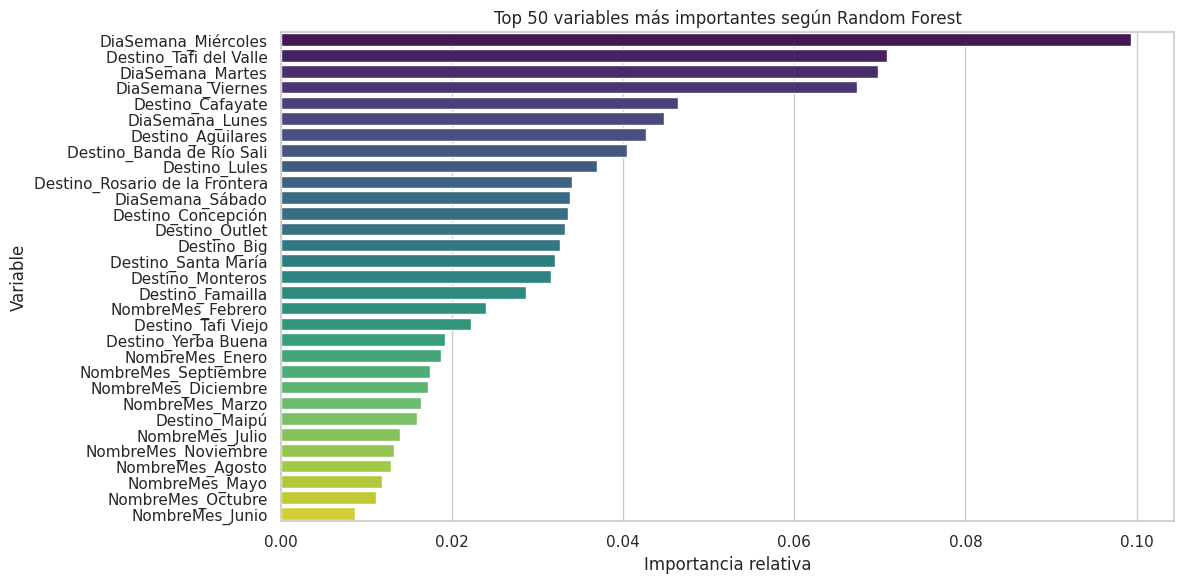

In [13]:
# Crear DataFrame con importancias
importancias = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': modelo_rf.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# Visualizar top 50 variables más importantes
plt.figure(figsize=(12, 6))
sns.barplot(
    data=importancias.head(50),
    x='Importancia',
    y='Variable',
    hue='Variable',
    palette='viridis',
    legend=False
)
plt.title("Top 50 variables más importantes según Random Forest")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


### Conclusión del análisis de importancia de Variables

El análisis de importancia de variables muestra cómo el modelo `RandomForestRegressor` utiliza las características anticipables para predecir el volumen diario transferido a cada sucursal.

Entre las variables más influyentes se destacan:

- **Día de la semana**: en particular, `Miércoles`, `Martes` y `Viernes` son los días más relevantes para el modelo, lo que sugiere que la distribución logística presenta un patrón semanal repetitivo.
  
- **Sucursal de destino**: múltiples sucursales tienen un peso significativo en la predicción, como `Tafí del Valle`, `Cafayate`, `Aguijares` y `Rosario de la Frontera`. Esto indica que algunas sucursales tienen comportamientos logísticos propios y consistentes en cuanto al volumen transferido.

- **Mes del año**: aunque con menor peso, ciertos meses como `Enero`, `Diciembre` y `Marzo` también contribuyen al modelo, reflejando una leve estacionalidad en la distribución logística.

En conjunto, este análisis confirma que el modelo basa sus decisiones principalmente en **patrones temporales (día de la semana)** y en el **comportamiento histórico particular de cada sucursal**. La estacionalidad mensual existe, pero tiene un impacto comparativamente menor.

Desde una perspectiva operativa, estos resultados refuerzan la idea de que:

- Las transferencias logísticas tienen un componente estructural (cronograma semanal fijo)
- Las sucursales deben considerarse individualmente al planificar la capacidad diaria
- El modelo puede aportar información útil para organizar turnos, secuencias de carga o definir días pico por punto de entrega




## 13. Conclusiones Finales




El objetivo de este proyecto fue desarrollar un modelo de predicción que permita anticipar el volumen logístico diario transferido a cada sucursal de una empresa de retail, utilizando únicamente variables anticipables antes del armado operativo (día de la semana, mes y sucursal de destino).

El enfoque se centró en construir un modelo que pudiera ser útil para la planificación logística diaria, como la asignación de camiones, la organización de turnos y la estimación de carga. Para ello se utilizaron modelos de regresión supervisada con diferentes técnicas, siendo `RandomForestRegressor` el que presentó el mejor desempeño.

---

####  Evaluación del modelo

El modelo Random Forest logró un coeficiente de determinación **R² de 0.3512**, lo que indica que fue capaz de explicar aproximadamente el **35% de la variabilidad del volumen transferido**. Si bien esta capacidad predictiva es moderada, los errores (MAE de 5.20 m³) se mantuvieron en niveles aceptables en muchos escenarios operativos, especialmente si se utiliza el modelo como herramienta complementaria.

Se probaron además otros algoritmos, incluyendo:
- `GradientBoostingRegressor`
- `Ridge Regression`
- `KNeighborsRegressor`

Ninguno de ellos superó al modelo de Random Forest en rendimiento, confirmando que este último es, por ahora, el enfoque más sólido para este contexto.

---

####  Limitaciones actuales del dataset

Uno de los hallazgos más importantes del análisis es que **el dataset en su estado actual no contiene suficiente información explicativa como para permitir una predicción eficiente y precisa** del volumen transferido. Al utilizar únicamente variables anticipables, se deja fuera una porción considerable de factores que realmente explican la variabilidad logística, como:

- Mix de productos y familias transferidas
- Acciones promocionales o comerciales
- Comportamiento real de la demanda por canal
- Stock disponible o pedidos pendientes

Esta limitación **no invalida el modelo**, sino que lo posiciona como un **primer paso estructurado**, sobre el cual se pueden sumar futuras mejoras.

---

####  Próximas oportunidades de mejora

Para aumentar la capacidad predictiva del modelo, se recomienda:

1. Incorporar variables operativas adicionales disponibles antes del armado del pedido:
   - Agenda comercial semanal (promociones, campañas)
   - Volumen estimado por familia o categoría de productos
   - Tipo o rol logístico de la sucursal

2. Aumentar la granularidad histórica:
   - Indicadores de carga promedio histórica ajustados por semana o mes
   - Incorporar efectos por quincena, fin de mes o inicio de campaña

3. Evaluar cambios de enfoque:
   - Predecir volumen **semanal** en lugar de diario
   - Modelos segmentados por zona o tipo de sucursal
   - Híbridos con lógica de clasificación + regresión

---

####  Conclusión final

Este modelo representa un **buen punto de partida para la automatización de la planificación logística**. Si bien sus resultados no son concluyentes, establece una base sólida, reproducible y fácilmente escalable para futuros desarrollos. La incorporación progresiva de variables relevantes permitirá construir un modelo más robusto, confiable y aplicable a la operación real.

En resumen, el trabajo realizado demuestra que, con un enfoque metodológico adecuado y validaciones rigurosas, es posible avanzar hacia la predicción anticipada de volumen logístico como herramienta estratégica dentro de la cadena de abastecimiento.